In [1]:
%matplotlib inline

import json
import numpy as np
import cv2
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
keypoints_dir = "data/openpose/0gks6ceq4eQ"

keypoints_frames_files = os.listdir(keypoints_dir)
keypoints_frames_files.sort(key=lambda fname: int(fname.split("_")[1]))

In [18]:
sample = None
file_name = None
count = 0

for keypoints_frames_file in keypoints_frames_files:
    json_file = open(os.path.join(keypoints_dir, keypoints_frames_file))
    keypts = json.loads(json_file.read())

    if len(keypts["people"]) > 0:
        if sum(keypts["people"][0]["hand_right_keypoints_2d"]) > 0:
            sample = keypts
            file_name = keypoints_frames_file
            count += 1
            if count > 100:   
                break

In [19]:
frame_t = int(file_name.split("_")[1])

print("Frame:", frame_t)

Frame: 337


In [86]:
pose_keypoints_2d = np.array(sample["people"][0]["pose_keypoints_2d"]).reshape(25, 3).astype(np.int64)
hand_left_keypoints_2d = np.array(sample["people"][0]["hand_left_keypoints_2d"]).reshape(21, 3).astype(np.int64)
hand_right_keypoints_2d = np.array(sample["people"][0]["hand_right_keypoints_2d"]).reshape(21, 3).astype(np.int64)

In [48]:
cap = cv2.VideoCapture("data/video/0gks6ceq4eQ.mp4")

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_t)
frame_exists, curr_frame = cap.read()

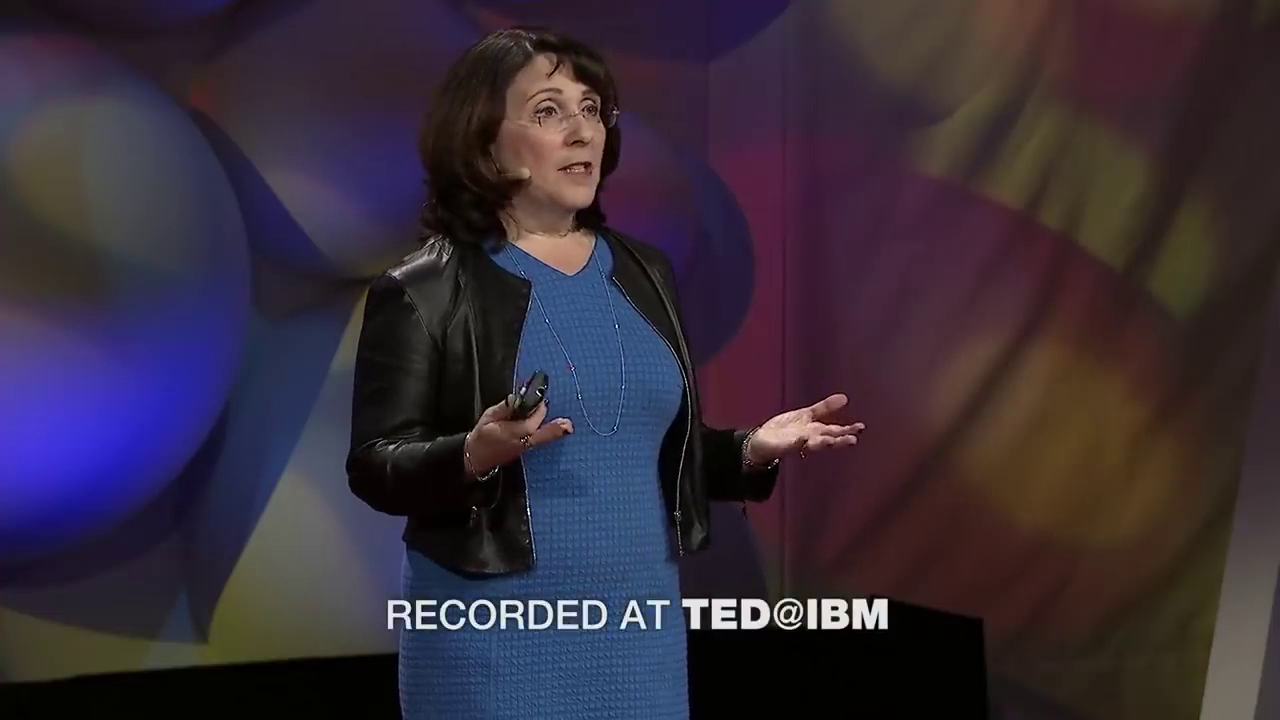

In [49]:
Image.fromarray(curr_frame[:, :, ::-1])

In [50]:
for x, y, c in hand_left_keypoints_2d:
    curr_frame = cv2.circle(curr_frame, (x,y), radius=1, color=(0, 0, 255), thickness=-1)

In [98]:
b1 = pose_keypoints_2d[1, :2]
b8 = pose_keypoints_2d[8, :2]

curr_frame = cv2.circle(curr_frame, (b1[0], b1[1]), radius=3, color=(0, 255, 0), thickness=-1)
curr_frame = cv2.circle(curr_frame, (b8[0], b8[1]), radius=3, color=(0, 255, 0), thickness=-1)

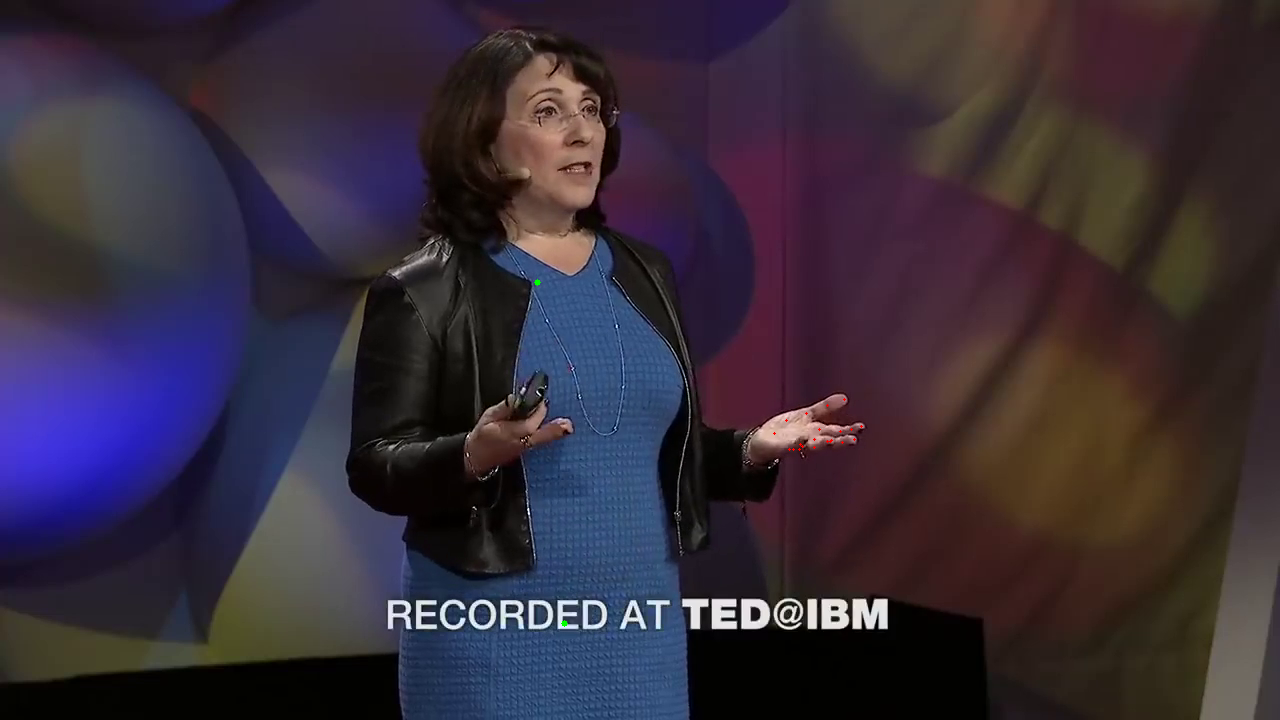

In [99]:
Image.fromarray(curr_frame[:, :, ::-1])

In [84]:
person_height = np.linalg.norm(b1 - b8)

scale = 100 / person_height

In [18]:
# Helper functions

def pre_process(X, scale=1):
    X[:, 0] = X[:, 0] - X[0, 0] 
    X[:, 1] = X[:, 1] - X[0, 1]
    # Flip over x axis
    X[:, 1] = -X[:, 1]
    return X * scale

def fill_missing_frames(x):
    return pd.DataFrame(np.array(x)).fillna(method="ffill").fillna(method="bfill").to_numpy()


def generate_keypoints(frame_ids, video_id, threshold=0.6):
    left_hand_landmarks_x = []
    left_hand_landmarks_y = []
    right_hand_landmarks_x = []
    right_hand_landmarks_y = []
    missing_frames = 0


    for frame_id in frame_ids:
        keypoints_frame_file = f"data/openpose/{video_id}/{video_id}_{frame_id:012d}_keypoints.json"

        json_file = open(keypoints_frame_file)
        keypts = json.loads(json_file.read())


        if len(keypts["people"]) == 1:
            pose_keypoints_2d = np.array(keypts["people"][0]["pose_keypoints_2d"]).reshape(25, 3).astype(np.int64)
            
            b1, b8 = pose_keypoints_2d[[1, 8], :2]
            person_height = np.linalg.norm(b1 - b8)
            
            if person_height > 0:
                scale = 100 / person_height 
                
                left_hand_exists = sum(keypts["people"][0]["hand_left_keypoints_2d"]) > 0
                right_hand_exists = sum(keypts["people"][0]["hand_right_keypoints_2d"]) > 0
                
                if left_hand_exists:
                    hand_left_keypoints_2d = np.array(keypts["people"][0]["hand_left_keypoints_2d"]).reshape(21, 3).astype(np.int64)
                    hand_left_keypoints_2d = pre_process(hand_left_keypoints_2d, scale)
                    left_hand_landmarks_x.append(hand_left_keypoints_2d[:, 0])
                    left_hand_landmarks_y.append(hand_left_keypoints_2d[:, 1])
                else:
                    missing_frames += 0.5
                    left_hand_landmarks_x.append([np.nan] * 21)
                    left_hand_landmarks_y.append([np.nan] * 21)
                
                if right_hand_exists:
                    hand_right_keypoints_2d = np.array(keypts["people"][0]["hand_right_keypoints_2d"]).reshape(21, 3).astype(np.int64)
                    hand_right_keypoints_2d = pre_process(hand_right_keypoints_2d, scale)
                    right_hand_landmarks_x.append(hand_right_keypoints_2d[:, 0])
                    right_hand_landmarks_y.append(hand_right_keypoints_2d[:, 1])
                else:
                    missing_frames += 0.5
                    right_hand_landmarks_x.append([np.nan] * 21)
                    right_hand_landmarks_y.append([np.nan] * 21)
            else:
                missing_frames += 1
                left_hand_landmarks_x.append([np.nan] * 21)
                left_hand_landmarks_y.append([np.nan] * 21)
                right_hand_landmarks_x.append([np.nan] * 21)
                right_hand_landmarks_y.append([np.nan] * 21)
                
        else:
            missing_frames += 1
            left_hand_landmarks_x.append([np.nan] * 21)
            left_hand_landmarks_y.append([np.nan] * 21)
            right_hand_landmarks_x.append([np.nan] * 21)
            right_hand_landmarks_y.append([np.nan] * 21)
            
    ratio = missing_frames / len(frame_ids)
    
    if ratio < threshold:
        landmarks = np.concatenate((left_hand_landmarks_x, left_hand_landmarks_y, right_hand_landmarks_x, right_hand_landmarks_y), axis=1)
        landmarks = fill_missing_frames(landmarks)
        return landmarks, True
    else:
        return None, False

## Generating annotations for one video

In [4]:
audio_file = "data/audio/0gks6ceq4eQ.wav"
video_file = "data/video/0gks6ceq4eQ.mp4"
caption_file = "data/captions/0gks6ceq4eQ.csv"

video_id = caption_file.split("/")[-1].split(".")[0]

fps = 10

In [5]:
captions = pd.read_csv(caption_file)

t, d = captions.iloc[26, [0, 1]]

In [6]:
start_ft = t * fps // 1000
end_ft = (t + d) * fps // 1000

print(f"Start frame: {start_ft}, End frame: {end_ft}")

Start frame: 1036, End frame: 1076


In [7]:
frame_ids = np.arange(start_ft, end_ft + 1)

In [23]:
landmarks, is_valid = generate_keypoints(frame_ids, video_id, threshold=0.4)

In [41]:
lx, ly, rx, ry = landmarks[:, :21], landmarks[:, 21:42], landmarks[:, 42:63], landmarks[:, 63:]

left_middle_finger_distance = np.sqrt(np.square(lx[:, 12]) + np.square(ly[:, 12]))
scale_left = 1 / np.percentile(left_middle_finger_distance, 95)

right_middle_finger_distance = np.sqrt(np.square(rx[:, 12]) + np.square(ry[:, 12]))
scale_right = 1 / np.percentile(right_middle_finger_distance, 95)

(array([[ 0.        , -0.10138137, -0.21197923, -0.3133606 , -0.38709251,
         -0.15207206, -0.26727816, -0.35944305, -0.43317495, -0.14746381,
         -0.24884519, -0.35944305, -0.44239144, -0.14746381, -0.23502045,
         -0.33179358, -0.41935022, -0.15207206, -0.22119572, -0.28110289,
         -0.33179358],
        [ 0.        , -0.10988724, -0.22435311, -0.32966171, -0.39834123,
         -0.16483085, -0.27471809, -0.36629079, -0.44870622, -0.15109495,
         -0.26098219, -0.37544806, -0.45786349, -0.14193768, -0.24266765,
         -0.34339761, -0.42581304, -0.14193768, -0.22435311, -0.288454  ,
         -0.35255488],
        [ 0.        , -0.10671859, -0.22271705, -0.33407557, -0.41759447,
         -0.16239785, -0.28303625, -0.3851149 , -0.45935391, -0.15775791,
         -0.27375637, -0.39439477, -0.47791367, -0.15775791, -0.25983656,
         -0.3619152 , -0.45007404, -0.16239785, -0.24591674, -0.3247957 ,
         -0.38975483],
        [ 0.        , -0.11719075, -0.22500

0.030056811130928646

(array([ 2.,  2.,  1.,  5.,  5.,  2.,  1.,  1.,  7., 15.]),
 array([ 8.2438441 , 10.79903602, 13.35422794, 15.90941987, 18.46461179,
        21.01980372, 23.57499564, 26.13018756, 28.68537949, 31.24057141,
        33.79576334]),
 <BarContainer object of 10 artists>)

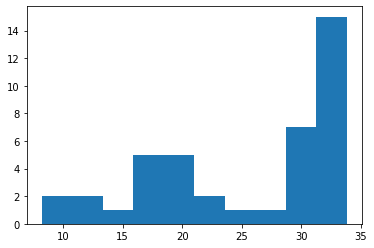

In [37]:
plt.hist(d)

33.27032916579077